# Project Exploration and Writeup

## Histogram of Oriented Gradients (HOG)

In [1]:
from vehicle_detection_utils import *
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload 
%autoreload 2

### Gather input data

In [2]:
vehicle_test_images = glob.glob("../project_data/vehicles/*/*.png")
nonvehicle_test_images = glob.glob("../project_data/non-vehicles/*/*.png")

In [3]:
print("Vehicle Images Size: %d" % len(vehicle_test_images))
print("Non-Vehicle Images Size: %d" % len(nonvehicle_test_images))

Vehicle Images Size: 8792
Non-Vehicle Images Size: 8968


HOG features are extracted by the functions **get_hog_features** and **extract_hog_features_from_img_list** used for different purposes at training time and inference time. These functions are located in the **vehicle_detection_utils.py** <br>
I started with the configuration from the lectures and started to vary the parameters to see if we have a more unique hog patterns for both positive and negative images.<br>



In [4]:
car_imgs = []
non_car_imgs = []
random_index = 0
num_images = 5
# read raw image data and normalize it 
for i in range(random_index, random_index+num_images):
    car_imgs.append(cv2.imread(vehicle_test_images[i]))
    non_car_imgs.append(cv2.imread(nonvehicle_test_images[i]))    

#### EXPLORE HOG PARAMETERS

In [27]:
def extract_hog_imgs(img_list, cspace='BGR2YCrCb', orient=9, pix_per_cell=8, cell_per_block=2):
    """
        Helper to extract hog features from an img list 
    """
    hog_feature_list = []
    for img in img_list:
        outputs = []
        copy_img = np.copy(img)
        copy_img = convert_color(np.copy(img), conv=cspace)
        copy_img = np.float32(img) / 255.0
        features, hog_images = get_hog_features(copy_img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True, hog_channel=3)
        outputs.append(img)
        outputs.extend(hog_images)
        hog_feature_list.append(outputs)
    return hog_feature_list


def plot_features(feature_list):
    plt.figure(figsize=(10, 10))
    nrows = len(feature_list)
    for i in range(len(feature_list)):
        for j in range(1, 5):
            plt.subplot(nrows, 4, i*4+j)
            plt.imshow(feature_list[i][j-1], cmap='gray')

### HOG FEATURES WITH YCrCb

In [20]:
## TRY OUT SOME FEATURES AND COMPARES
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace = 'BGR2YCrCb'
# DEFAULT
test_car_hog_1 = extract_hog_imgs(car_imgs)
test_non_car_hog_1 = extract_hog_imgs(non_car_imgs)

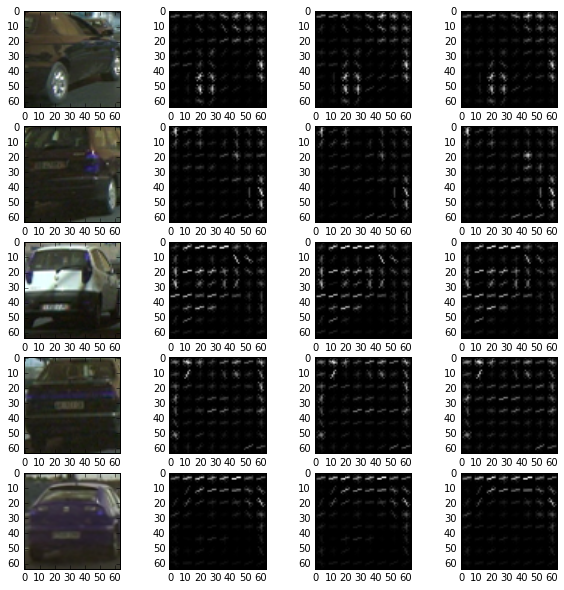

In [29]:
plot_features(test_car_hog_1)

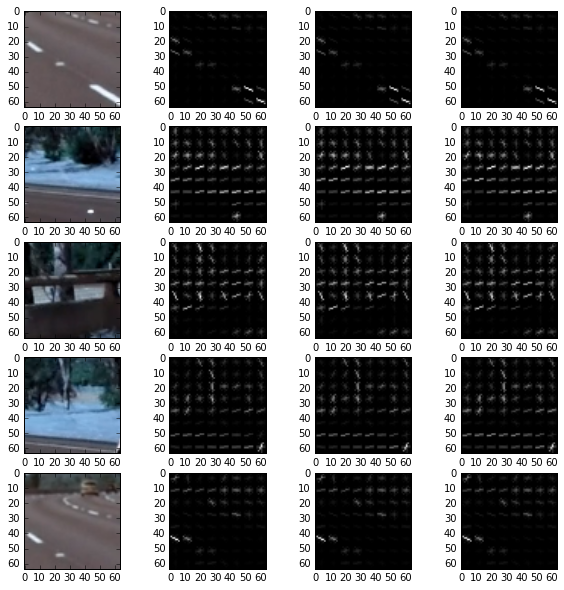

In [30]:
plot_features(test_non_car_hog_1)

In [34]:
## TRY DIFFERENT PARAMETERS
## TRY OUT SOME FEATURES AND COMPARES
orient = 12
pix_per_cell = 16
cell_per_block = 2
cspace = 'BGR2YCrCb'
# DEFAULT
test_car_hog_2 = extract_hog_imgs(car_imgs)
test_non_car_hog_2 = extract_hog_imgs(non_car_imgs)

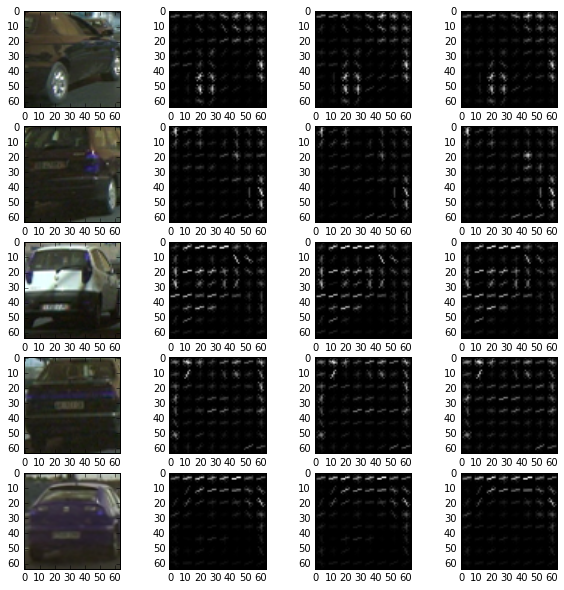

In [31]:
plot_features(test_car_hog_2)

NONCAR HOG FEATURES
CAR HOG FEATURES


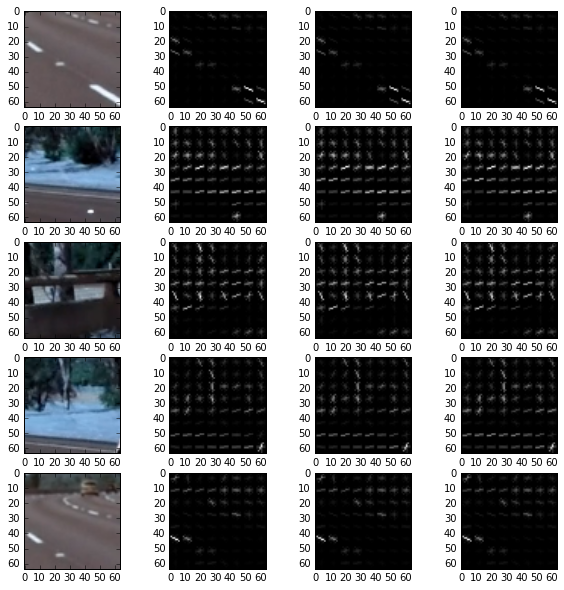

In [26]:
# NONCAR HOG FEATURES
print ("NONCAR HOG FEATURES")
plot_features(test_non_car_hog_2)

### HOG FEATURES WITH HLS

In [37]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace = 'BGR2HLS'

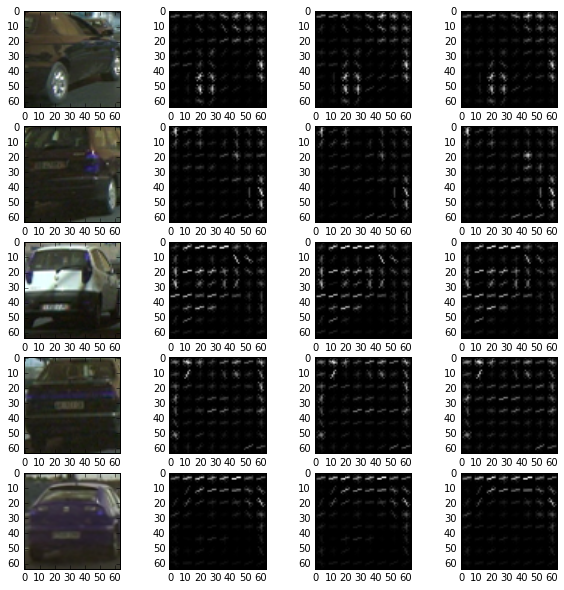

In [38]:
test_car_hog_2 = extract_hog_imgs(car_imgs)
test_non_car_hog_2 = extract_hog_imgs(non_car_imgs)
plot_features(test_car_hog_1)

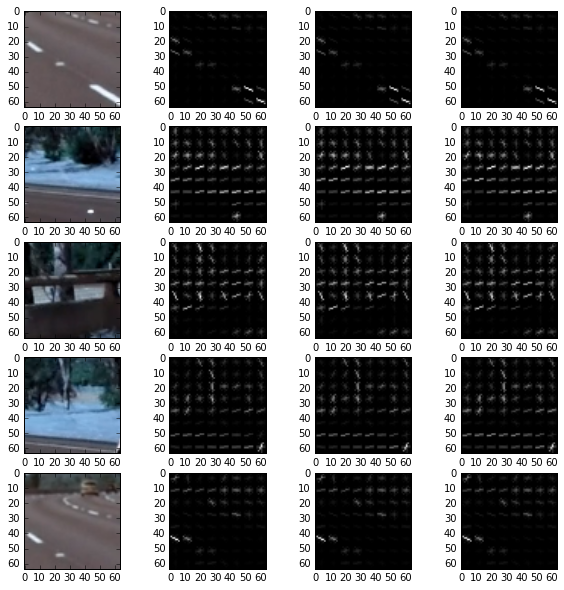

In [39]:
test_non_car_hog_2 = extract_hog_imgs(non_car_imgs)
plot_features(test_non_car_hog_1)

We can see the hog images of the car pictures has unique patterns at specific locations the reflects the shape of the car while the non-car images are all random pattern. Both color spaces show distinguish hog features between car and non-car, therefore, I decided to time how fast it take to extract hog features to decide which color spaces to use for extracting hog features because this is the major time consuming part of the pipeline. Also, I decided to keep the orient at 9 and evaluate the performance first before increase the orient values which might affect performance of the pipeline

In [45]:
import time
def profile_extract_time(img_list, cspace=cspace):
    t1 = time.time()
    extract_hog_imgs(img_list, cspace=cspace)
    t2 = time.time()
    print ("Total time for extracting all hog images for %s is %.2f " % (cspace, t2-t1))

In [50]:
car_imgs = []
non_car_imgs = []
random_index = 0
num_images = 1000
# read raw image data and normalize it 
for i in range(random_index, random_index+num_images):
    car_imgs.append(cv2.imread(vehicle_test_images[i]))
    non_car_imgs.append(cv2.imread(nonvehicle_test_images[i]))    

In [51]:
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2HLS")
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2YCrCb")
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2LUV")
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2YUV")

Total time for extracting all hog images for BGR2HLS is 135.25 
Total time for extracting all hog images for BGR2YCrCb is 136.06 
Total time for extracting all hog images for BGR2LUV is 144.65 
Total time for extracting all hog images for BGR2YUV is 180.60 


Based on the above result, I select YCrCb as the color space while HLS might also be a good options to try if the performance of YCrCb is not too good.

## TRAIN CLASSIFIER 

In [52]:
from sklearn.model_selection import train_test_split
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import pickle
import time

### EXTRACT ALL IMAGE FEATURES

In [14]:
vehicle_files = glob.glob('../project_data/vehicles/*/*.png')
nonvehicle_files = glob.glob('../project_data/non-vehicles/*/*.png')
print("Number of car images %d" % len(vehicle_files))
print("Number of non-car images %d" % len(nonvehicle_files))

Number of car images 8792
Number of non-car images 8968


The data set for positive and negative cases looks balance here.

In [15]:
# extract hog and color features
vehicle_features = extract_featurres_from_img_list(vehicle_files)
nonvehicle_features = extract_featurres_from_img_list(nonvehicle_files)
nonvehicle_labels = np.zeros(len(nonvehicle_features))
# created labels
vehicle_labels = np.ones(len(vehicle_features))
labels = np.hstack((vehicle_labels, nonvehicle_labels))
# stack dataset
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)
X = X.squeeze()

In [16]:
print ("X shape: %s" % str(X.shape))
print ("Y(labels) shape: %s" % str(labels.shape))

X shape: (17760, 8460)
Y(labels) shape: (17760,)


Split data into train and test sets. Also, normalize data with scaler class from sklearn.

In [17]:
rand_state = np.random.randint(0, 100)
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.2, random_state=rand_state)

In [18]:
X_scaler = get_scaler_from_feature_vectors(X_train)
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In order to search for best parameters, I used GridSearchCV to find the best C values to train the dataset

In [19]:
svc = LinearSVC()
parameters = {'C':[1.0, 0.1, 0.001, 10]}
search = GridSearchCV(svc, parameters)
search.fit(scaled_X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1.0, 0.1, 0.001, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [21]:
print ("Best C values %s " % str(search.best_params_))
svc = search.best_estimator_

Best C values {'C': 0.001} 


Save the SVM model and scaler to pickle file 

In [24]:
# svc model file
svc_pickle_file = 'svc_best_model.pkl'
with open(svc_pickle_file, 'wb') as f:
    pickle.dump(svc, f)

    # svc scaler file 
svc_scaler_file = 'svc_best_scaler.pkl'
with open(svc_scaler_file, 'wb') as f:
    pickle.dump(X_scaler, f)

## SLIDING WINDOWS APROACH

Load the model from pickle files

In [83]:
import pickle
import cv2
svc_model = pickle.load(open('svc_best_model.pkl','rb'))
scaler = pickle.load(open('svc_best_scaler.pkl','rb'))
# default parameters experimenting with sliding windows
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32
scales = [1.5, 2]
cell_per_step = 1
threshold = 5
# chop the image 
ystart = 400
ystop =600

In [84]:
def test_sliding_windows(img_path):
    heat_maps = []
    heat_map = np.zeros((720, 1280))
    t1 = time.time()
    for scale in scales:
        orig_frame = cv2.imread(img_path)
        print(orig_frame.shape)
        heat_map, test_img = slide_windows_and_update_heat_map(orig_frame,
                                        ystart,
                                        ystop,                                                    
                                        scale,
                                        svc_model,
                                        scaler,
                                        orient,
                                        pix_per_cell,
                                        cell_per_block,
                                        spatial_size,
                                        hist_bins,
                                        window_size=80,
                                        cells_per_step=cell_per_step,
                                        threshold=threshold,
                                        heat_map=heat_map)
    t2 = time.time()
    print ("Total Time : %.2f" % (t2-t1))
    heat_maps.append(heat_map)
    
    # show heat maps here 
    heat_map = np.average(np.array(heat_maps), axis=0)
    print (heat_map)
    heat_map[heat_map <= threshold] = 0
    labels = label(heat_map)
    draw_bounding_boxes_from_labels(orig_frame, labels)
    cv2.line(orig_frame, (0,ystart), (orig_frame.shape[1],ystart),(255,0,0),2)
    cv2.line(orig_frame, (0,ystop), (orig_frame.shape[1],ystop),(0,255,0),2)
    plt.figure()
    plt.imshow(heat_map, cmap='gray')
    plt.figure()
    plt.title("Final Detections")
    plt.imshow(orig_frame)
    plt.figure()
    plt.title("All detected windows")
    plt.imshow(test_img)

(720, 1280, 3)
hog shape (15, 105, 2, 2, 9)
Total Window count 891
(720, 1280, 3)
hog shape (11, 79, 2, 2, 9)
Total Window count 365
Total Time : 1.24
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
BBox :  ((804, 400), (947, 579))  bbox area: 25597
BBox :  ((1056, 400), (1279, 603))  bbox area: 45269
BBox :  ((560, 412), (735, 575))  bbox area: 28525
BBox :  ((64, 432), (239, 575))  bbox area: 25025


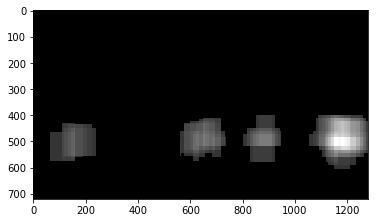

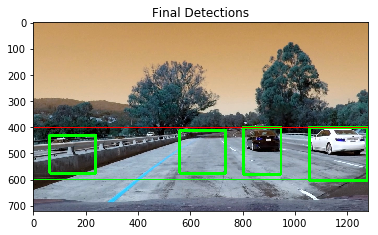

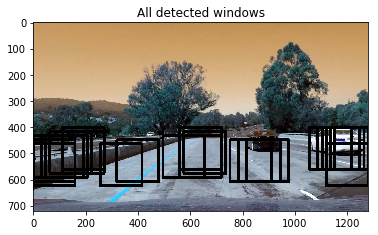

In [85]:
test_sliding_windows("../test_images/test1.jpg")

(720, 1280, 3)
hog shape (15, 105, 2, 2, 9)
Total Window count 891
(720, 1280, 3)
hog shape (11, 79, 2, 2, 9)
Total Window count 365
Total Time : 1.20
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
BBox :  ((132, 412), (143, 519))  bbox area: 1177
BBox :  ((156, 412), (239, 519))  bbox area: 8881
BBox :  ((480, 484), (599, 603))  bbox area: 14161


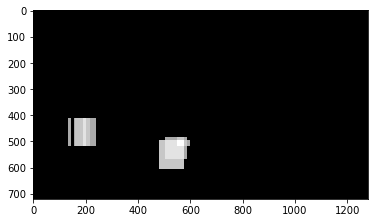

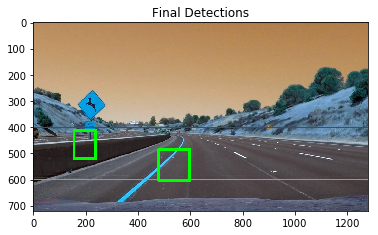

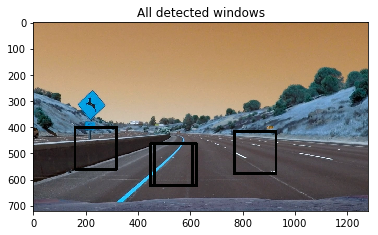

In [86]:
test_sliding_windows("../test_images/test2.jpg")

(720, 1280, 3)
hog shape (15, 105, 2, 2, 9)
Total Window count 891
(720, 1280, 3)
hog shape (11, 79, 2, 2, 9)
Total Window count 365
Total Time : 1.21
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
BBox :  ((768, 400), (1247, 603))  bbox area: 97237
BBox :  ((204, 412), (207, 519))  bbox area: 321
BBox :  ((216, 412), (299, 519))  bbox area: 8881
BBox :  ((12, 464), (131, 559))  bbox area: 11305
BBox :  ((564, 464), (683, 603))  bbox area: 16541
BBox :  ((496, 496), (527, 519))  bbox area: 713


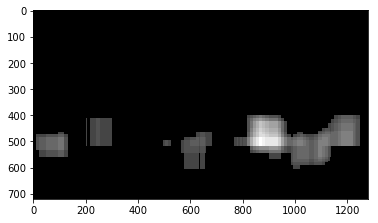

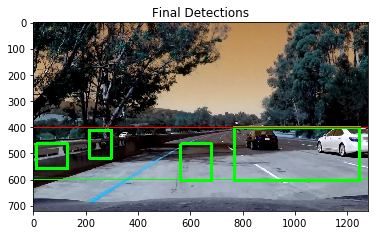

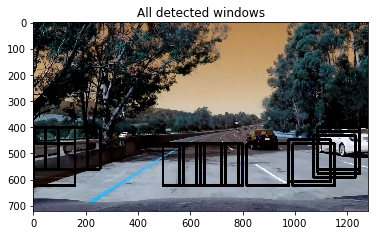

In [87]:
test_sliding_windows("../test_images/test5.jpg")

With a two fixed scales 1.5, 2 running through the whole images. We have quite some false positive and also the processing time for each frame is about 1.2 sec which would be too slow.

In order to address the slowness and false positive issues, I decided to use the following approaches (after a lot of trial and errors with various scales and threshold):
- Average the heatmap across at least 10 frames 
- Apply multiscale windows idea from the lecture and set a certain sizes of windows for a specific area of the images rather than using using each scale for the whole images which can cause high latency. 

I decided only run the search area with height from 400 to 600 as other area of the images are not relevant with vehicle detections. 
The below tuples correspondent to each search area of the images. We only run one scan of each scale from left to write without sliding for every pixel in the vertical direction. This would save sometimes and avoid false positive:
- (scale, ystart, ystop)
- (1,400,464)
- (1,410,474)
- (1.5,420,516)
- (1.5,400,496)
- (2,400,528)



In [88]:
# new sliding windows function 
heat_maps = []
scales = [(1,400,464),(1,410,474),(1.5,420,516),(1.5,400,496),(2,400,528)]
def test_sliding_windows_new_approach(img_path):
    heat_map = np.zeros((720, 1280))
    t1 = time.time()
    for i, (scale, ystart, ystop) in enumerate(scales):
        orig_frame = cv2.imread(img_path)
        print(orig_frame.shape)
        heat_map, test_img = slide_windows_and_update_heat_map(orig_frame,
                                        ystart,
                                        ystop,                                                    
                                        scale,
                                        svc_model,
                                        scaler,
                                        orient,
                                        pix_per_cell,
                                        cell_per_block,
                                        spatial_size,
                                        hist_bins,
                                        window_size=80,
                                        cells_per_step=cell_per_step,
                                        threshold=threshold,
                                        heat_map=heat_map)
    t2 = time.time()
    print ("Total Time : %.2f" % (t2-t1))
    heat_maps.append(heat_map)
    
    # show heat maps here 
    heat_map = np.average(np.array(heat_maps), axis=0)
    print (heat_map)
    heat_map[heat_map <= threshold] = 0
    labels = label(heat_map)
    draw_bounding_boxes_from_labels(orig_frame, labels)
    cv2.line(orig_frame, (0,ystart), (orig_frame.shape[1],ystart),(255,0,0),2)
    cv2.line(orig_frame, (0,ystop), (orig_frame.shape[1],ystop),(0,255,0),2)
    plt.figure()
    plt.imshow(heat_map, cmap='gray')
    plt.figure()
    plt.title("Final Detections")
    plt.imshow(orig_frame)
    plt.figure()
    plt.title("All detected windows")
    plt.imshow(test_img)

(720, 1280, 3)
hog shape (7, 159, 2, 2, 9)
Total Window count 153
(720, 1280, 3)
hog shape (7, 159, 2, 2, 9)
Total Window count 153
(720, 1280, 3)
hog shape (7, 105, 2, 2, 9)
Total Window count 99
(720, 1280, 3)
hog shape (7, 105, 2, 2, 9)
Total Window count 99
(720, 1280, 3)
hog shape (7, 79, 2, 2, 9)
Total Window count 73
Total Time : 0.98
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
BBox :  ((768, 400), (959, 539))  bbox area: 26549
BBox :  ((1116, 400), (1271, 539))  bbox area: 21545


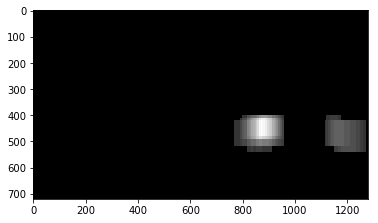

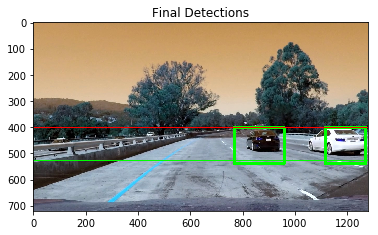

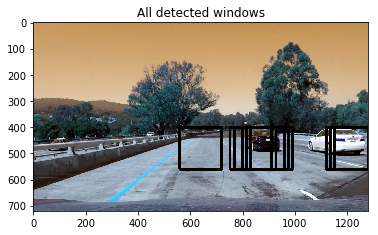

In [89]:
test_sliding_windows_new_approach("../test_images/test1.jpg")

(720, 1280, 3)
hog shape (7, 159, 2, 2, 9)
Total Window count 153
(720, 1280, 3)
hog shape (7, 159, 2, 2, 9)
Total Window count 153
(720, 1280, 3)
hog shape (7, 105, 2, 2, 9)
Total Window count 99
(720, 1280, 3)
hog shape (7, 105, 2, 2, 9)
Total Window count 99
(720, 1280, 3)
hog shape (7, 79, 2, 2, 9)
Total Window count 73
Total Time : 0.95
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
BBox :  ((768, 400), (947, 519))  bbox area: 21301
BBox :  ((1152, 420), (1187, 519))  bbox area: 3465


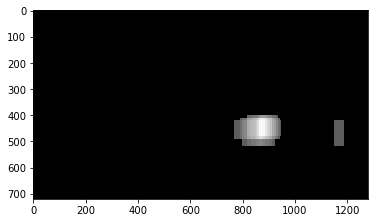

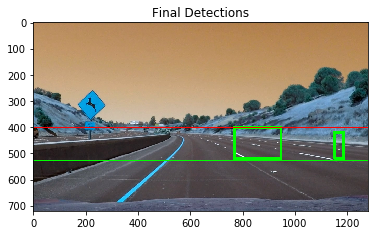

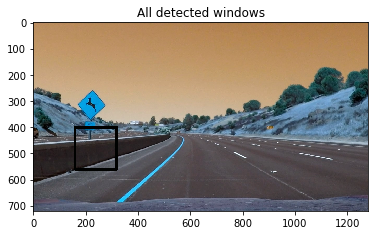

In [90]:
test_sliding_windows_new_approach("../test_images/test2.jpg")

(720, 1280, 3)
hog shape (7, 159, 2, 2, 9)
Total Window count 153
(720, 1280, 3)
hog shape (7, 159, 2, 2, 9)
Total Window count 153
(720, 1280, 3)
hog shape (7, 105, 2, 2, 9)
Total Window count 99
(720, 1280, 3)
hog shape (7, 105, 2, 2, 9)
Total Window count 99
(720, 1280, 3)
hog shape (7, 79, 2, 2, 9)
Total Window count 73
Total Time : 0.98
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
BBox :  ((768, 400), (959, 519))  bbox area: 22729
BBox :  ((1140, 410), (1231, 519))  bbox area: 9919


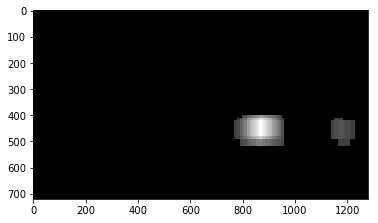

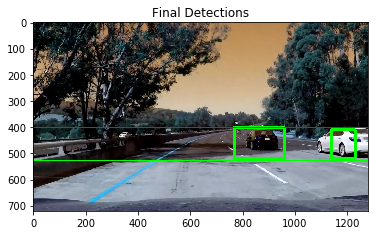

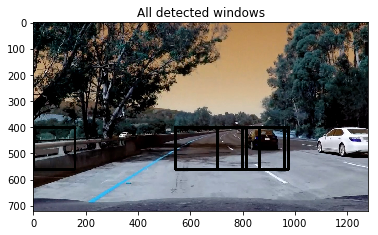

In [91]:
test_sliding_windows_new_approach("../test_images/test5.jpg")

This approach shows less false positive which can be filtered out more using heatmap average of the last 10 frames which is implemented in the pipeline class in the file **svm_detection_pipeline.py**. 

### PROCESS PROJECT VIDEO

In [2]:
from svm_detection_pipeline import *
import cv2
print (cv2.__version__)
pipeline = VehicleDetectionPipeline('svc_best_model.pkl', 'svc_best_scaler.pkl')
pipeline.run('../project_video.mp4', save_video=True, debug=False)

3.4.2
Start Video Processing
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Wind

Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  1.5
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  1.8
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  1.8
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  2.5
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.1
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.6
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape 

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  0.7
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  0.6
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  0.8
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape 

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  2.2
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  2.1
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  2.1
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape 

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.2
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.0
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.5
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape 

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.7
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.9
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  4.0
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape 

hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  4.2
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  4.0
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  4.0
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105,

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  6.3
BBox :  ((1152, 400), (1247, 495))  bbox area: 9025
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  6.3
BBox :  ((1152, 400), (1247, 495))  bbox area: 9025
BBox :  ((1128, 420), (1135, 473))  bbox area: 371
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 

hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.2
BBox :  ((1104, 400), (1231, 515))  bbox area: 14605
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.3
BBox :  ((1104, 400), (1231, 515))  bbox area: 14605
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.4
BBox :  ((1104, 400), (1223, 515))  

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.8
BBox :  ((1056, 400), (1223, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.8
BBox :  ((1056, 400), (1223, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.6
BBox :  ((1056, 400), (1223, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.7
BBox :  ((1080, 400), (1223, 515))  bbox area: 16445
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.7
BBox :  ((1080, 400), (1223, 515))  bbox area: 16445
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.6
BBox :  ((1080, 400), (1223, 515))  bbox area: 16445
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.2
BBox :  ((1056, 420), (1215, 515))  bbox area: 15105
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.3
BBox :  ((1056, 420), (1215, 515))  bbox area: 15105
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.5
BBox :  ((1056, 420), (1215, 515))  bbox area: 15105
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.9
BBox :  ((1008, 400), (1199, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.7
BBox :  ((1008, 400), (1199, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  8.4
BBox :  ((1024, 400), (1199, 515))  bbox area: 20125
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.1
BBox :  ((984, 400), (1175, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.7
BBox :  ((984, 400), (1175, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.1
BBox :  ((984, 400), (1175, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total W

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.3
BBox :  ((976, 400), (1127, 515))  bbox area: 17365
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.6
BBox :  ((960, 400), (1127, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.0
BBox :  ((960, 400), (1127, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total W

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.9
BBox :  ((936, 400), (1103, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.3
BBox :  ((936, 400), (1103, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.1
BBox :  ((936, 400), (1103, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.4
BBox :  ((912, 400), (1079, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.6
BBox :  ((912, 400), (1079, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.4
BBox :  ((912, 400), (1079, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Wi

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.3
BBox :  ((936, 400), (1055, 495))  bbox area: 11305
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.3
BBox :  ((936, 400), (1055, 495))  bbox area: 11305
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.5
BBox :  ((936, 400), (1055, 495))  bbox area: 11305
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Wi

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.0
BBox :  ((960, 400), (1055, 495))  bbox area: 9025
BBox :  ((592, 420), (671, 495))  bbox area: 5925
BBox :  ((736, 420), (743, 473))  bbox area: 371
BBox :  ((768, 420), (791, 463))  bbox area: 989
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  6.9
BBox :  ((960, 400), (1039, 495))  bbox area: 7505
BBox :  ((736, 410), (799, 473))  bbox area: 3969
BBox :  ((624, 420), (671, 495))  bbox area: 3525
BBox :  ((936, 420), (943, 473))  

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.2
BBox :  ((896, 400), (1055, 495))  bbox area: 15105
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.4
BBox :  ((912, 400), (1055, 495))  bbox area: 13585
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Windo

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  6.4
BBox :  ((912, 410), (1007, 495))  bbox area: 8075
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  6.5
BBox :  ((912, 410), (1007, 495))  bbox area: 8075
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window co

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.2
BBox :  ((912, 410), (991, 473))  bbox area: 4977
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.2
BBox :  ((912, 410), (991, 473))  bbox area: 4977
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window coun

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.3
BBox :  ((896, 410), (991, 473))  bbox area: 5985
BBox :  ((880, 420), (887, 463))  bbox area: 301
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.9
BBox :  ((864, 410), (991, 473))  bbox area: 8001
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  6.5
BBox :  ((912, 410), (959, 473))  bbox area: 2961
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.0
BBox :  ((896, 410), (975, 473))  bbox area: 4977
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  7.2
BBox :  ((896, 410), (975, 473))  bbox area: 4977
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window c

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  14.0
BBox :  ((696, 400), (991, 495))  bbox area: 28025
BBox :  ((648, 420), (671, 495))  bbox area: 1725
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  13.6
BBox :  ((768, 400), (991, 495))  bbox area: 21185
BBox :  ((704, 420), (719, 495))  bbox area: 1125
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  13.2
BBox :  ((816, 400), (991, 495))  bbox area: 16625
40

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.6
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.6
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.8
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  5.4
BBox :  ((912, 420), (959, 473))  bbox area: 2491
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  5.0
BBox :  ((912, 420), (959, 473))  bbox area: 2491
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window coun

400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  4.0
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  4.3
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  4.6
BBox :  ((936, 420), (943, 473))  bbox area: 371
BBox :  ((1008, 420), (1031

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.5
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.7
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  3.8
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  17.4
BBox :  ((1080, 400), (1247, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.9
BBox :  ((1056, 400), (1247, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.7
BBox :  ((1056, 400), (1247, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
To

hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.8
BBox :  ((992, 400), (1247, 515))  bbox area: 29325
BBox :  ((936, 420), (943, 473))  bbox area: 371
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.2
BBox :  ((984, 400), (1247, 515))  bbox area: 30245
BBox :  ((928, 420), (943, 473))  bbox area: 795
BBox :  ((960, 420), (975, 473))  bbox area: 795
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 1

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.8
BBox :  ((912, 400), (1223, 515))  bbox area: 35765
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.9
BBox :  ((912, 400), (1223, 515))  bbox area: 35765
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.1
BBox :  ((912, 400), (1215, 515))  bbox area: 34845
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.3
BBox :  ((896, 400), (1151, 515))  bbox area: 29325
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.1
BBox :  ((896, 400), (1151, 515))  bbox area: 29325
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  14.9
BBox :  ((896, 400), (1151, 515))  bbox area: 29325
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  17.3
BBox :  ((888, 400), (1119, 515))  bbox area: 26565
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  17.6
BBox :  ((888, 400), (1103, 515))  bbox area: 24725
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  17.6
BBox :  ((888, 400), (1103, 515))  bbox area: 24725
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.3
BBox :  ((864, 400), (1055, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.5
BBox :  ((864, 400), (1055, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.5
BBox :  ((864, 400), (1055, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  18.9
BBox :  ((840, 400), (1031, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  18.8
BBox :  ((840, 400), (1031, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  18.6
BBox :  ((840, 400), (1031, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.7
BBox :  ((816, 400), (1031, 515))  bbox area: 24725
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.8
BBox :  ((816, 400), (1031, 515))  bbox area: 24725
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.6
BBox :  ((816, 400), (1039, 515))  bbox area: 25645
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.2
BBox :  ((816, 400), (1079, 515))  bbox area: 30245
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.0
BBox :  ((816, 400), (1079, 515))  bbox area: 30245
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.9
BBox :  ((816, 400), (1079, 495))  bbox area: 24985
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  17.1
BBox :  ((800, 400), (1103, 515))  bbox area: 34845
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  17.1
BBox :  ((800, 400), (1103, 515))  bbox area: 34845
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.9
BBox :  ((800, 400), (1103, 515))  bbox area: 34845
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total

BBox :  ((984, 400), (1151, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.0
BBox :  ((792, 400), (959, 495))  bbox area: 15865
BBox :  ((984, 400), (1151, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  16.1
BBox :  ((792, 400), (959, 495))  bbox area: 15865
BBox :  ((984, 400), (1151, 515))  bbox area: 19205
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516


400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  13.6
BBox :  ((792, 400), (935, 495))  bbox area: 13585
BBox :  ((1008, 400), (1199, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  13.9
BBox :  ((792, 400), (935, 495))  bbox area: 13585
BBox :  ((1024, 400), (1199, 515))  bbox area: 20125
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50


BBox :  ((1024, 400), (1215, 515))  bbox area: 21965
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.0
BBox :  ((768, 400), (943, 495))  bbox area: 16625
BBox :  ((1032, 400), (1215, 515))  bbox area: 21045
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  15.3
BBox :  ((768, 400), (943, 495))  bbox area: 16625
BBox :  ((1032, 400), (1215, 515))  bbox area: 21045
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 5

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  12.7
BBox :  ((648, 400), (767, 515))  bbox area: 13685
BBox :  ((792, 400), (935, 495))  bbox area: 13585
BBox :  ((1080, 410), (1223, 515))  bbox area: 15015
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  12.7
BBox :  ((648, 400), (767, 515))  bbox area: 13685
BBox :  ((816, 400), (935, 495))  bbox area: 11305
BBox :  ((1104, 410), (1215, 515))  bbox area: 11655
BBox :  ((792, 420), (799, 463))  bbox area: 301
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  13.4
BBox :  ((744, 400), (935, 495))  bbox area: 18145
BBox :  ((1128, 410), (1215, 473))  bbox area: 5481
BBox :  ((672, 420), (687, 463))  bbox area: 645
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  13.6
BBox :  ((720, 400), (935, 495))  bbox area: 20425
BBox :  ((672, 420), (687, 463))  bbox area: 645
BBox :  ((696, 420), (703, 463))  bbox area: 301
BBox :  ((1136, 420), (1183, 473))  bbox area: 2491
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
T

BBox :  ((984, 420), (1007, 495))  bbox area: 1725
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.3
BBox :  ((816, 400), (1007, 495))  bbox area: 18145
BBox :  ((1128, 400), (1247, 495))  bbox area: 11305
BBox :  ((1024, 420), (1031, 495))  bbox area: 525
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.3
BBox :  ((816, 400), (1031, 495))  bbox area: 20425
BBox :  ((1128, 400), (1247, 495))  bbox area: 11305
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog 

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.1
BBox :  ((816, 400), (943, 473))  bbox area: 9271
BBox :  ((1120, 400), (1199, 495))  bbox area: 7505
BBox :  ((1088, 420), (1103, 495))  bbox area: 1125
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.4
BBox :  ((816, 400), (943, 473))  bbox area: 9271
BBox :  ((1088, 420), (1103, 495))  bbox area: 1125
BBox :  ((1120, 420), (1183, 495))  bbox area: 4725
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79

hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.5
BBox :  ((816, 400), (943, 473))  bbox area: 9271
BBox :  ((1152, 400), (1215, 495))  bbox area: 5985
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.5
BBox :  ((816, 400), (943, 473))  bbox area: 9271
BBox :  ((1152, 400), (1199, 495))  bbox area: 4465
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog 

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.6
BBox :  ((816, 400), (935, 473))  bbox area: 8687
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.7
BBox :  ((816, 400), (935, 473))  bbox area: 8687
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.4
BBox :  ((816, 400), (927, 473))  bbox area: 8103
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Windo

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  11.0
BBox :  ((800, 400), (911, 473))  bbox area: 8103
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.6
BBox :  ((800, 400), (911, 473))  bbox area: 8103
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.3
BBox :  ((800, 400), (911, 473))  bbox area: 8103
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Windo

BBox :  ((1080, 400), (1215, 495))  bbox area: 12825
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.0
BBox :  ((800, 400), (911, 473))  bbox area: 8103
BBox :  ((1080, 400), (1215, 495))  bbox area: 12825
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.8
BBox :  ((800, 400), (911, 473))  bbox area: 8103
BBox :  ((1080, 400), (1215, 495))  bbox area: 12825
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516


400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.6
BBox :  ((792, 400), (911, 473))  bbox area: 8687
BBox :  ((1080, 420), (1175, 495))  bbox area: 7125
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.7
BBox :  ((792, 400), (935, 473))  bbox area: 10439
BBox :  ((1080, 420), (1175, 495))  bbox area: 7125
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.6
BBox :  ((800, 400), (911, 473))  bbox area: 8103
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.7
BBox :  ((800, 400), (911, 495))  bbox area: 10545
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.8
BBox :  ((800, 400), (911, 495))  bbox area: 10545
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Win

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.1
BBox :  ((800, 400), (895, 473))  bbox area: 6935
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.1
BBox :  ((800, 400), (895, 473))  bbox area: 6935
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.2
BBox :  ((816, 400), (911, 473))  bbox area: 6935
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Windo

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  9.8
BBox :  ((792, 400), (879, 473))  bbox area: 6351
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.0
BBox :  ((784, 400), (879, 473))  bbox area: 6935
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window count 77
420 516
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 496
hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.2
BBox :  ((784, 400), (879, 473))  bbox area: 6935
400 464
hog shape (7, 159, 2, 2, 9)
Total Window count 77
410 474
hog shape (7, 159, 2, 2, 9)
Total Window

hog shape (7, 105, 2, 2, 9)
Total Window count 50
400 528
hog shape (7, 79, 2, 2, 9)
Total Window count 37
heat map val:  10.0
BBox :  ((768, 400), (863, 473))  bbox area: 6935
BBox :  ((1032, 420), (1039, 473))  bbox area: 371
BBox :  ((1216, 420), (1223, 463))  bbox area: 301
Clean up and Close


The output file is named: **output.avi**